# Efficient algorithm fow warping SAR imagery with motion compensation
## Anton Korosov<sup>1</sup>, Anna Telegina<sup>2</sup>
### 1. Nansen Environmenatl and Remote Sensing Centre (NERSC), Bergen, Norway
### 2. The Arctic University of Norway (UiT), Tromso, Norway
---------
## Introduction

Imagery from synthetic aperture radar (SAR) provides invaluable information about sea ice surface and used widely for operational monitoring.

Sea ice is in continuous motion under influence of wind and ocean currents. Therefore signature of sea ice on two SAR images of the same place acquired with some time separation cannot be directly compared. 

We developed a method for co-registration of SAR images with compensation for ice drift (or any other *a priori* known motion of ground targets).

## Methodology

Co-registration is performed by warping of one or both images from their original geometries to a new, common geometry. Co-registration with drift compensation is also performed by warping, but motion is taken into account during warping of one of the images.

If we denote the brightness of the pixels of the first SAR image by $\mathbf{I_1}$ then the brightness of the warped image can be comuted as:

$\mathbf{I_w} = \mathcal{M_I} (\mathbf{I_1}, \mathbf{R_w}, \mathbf{C_w})$.            (1)

$\mathcal{M_I}$ is the operation of resampling from the original coordinates of $\mathbf{I_1}$ to the new coordinates $\mathbf{R_w}$ and $\mathbf{C_w}$. The resampling is performed using function `map_coordinates` from the Python library `scipy` with nearest neigbour inteporlation. The original coordinates used are the row and column coordinates of all pixels of the image $\mathbf{I_1}$, and the new coordinates $\mathbf{R_w}$ and $\mathbf{C_w}$ are the row and column coordinates of all pixels on the warped image. Note that bold roman is used to denote $\mathbf{R_w}$ and $\mathbf{C_w}$ as matrices with the size of $\mathbf{I_w}$. These are computed as:

$\mathbf{R_w} = \mathcal{M_R} (\mathbf{R_2}, \mathbf{C_2})$            (2)

$\mathbf{C_w} = \mathcal{M_C} (\mathbf{R_2}, \mathbf{C_2})$            (3)

$\mathcal{M_R}$ and $\mathcal{M_C}$ are linear interpolators. They are applied to full size matrices of row/column coordinates of the second image, $\mathbf{R_2}$ and $\mathbf{C_2}$. 

The interpolators are trained unsing the function `LinearNDInterpolator` from the Python library `scipy` as follows:

$\mathcal{M_R} = \mathcal{T} (r_2, c_2, r_1)$            (4)

$\mathcal{M_C} = \mathcal{T} (r_2, c_2, c_1)$            (5)

Training $\mathcal{T}$ is performed on vectors of row and column coordinates on the first and the second SAR images: ($r_1$, $c_1$) and ($r_2$, $c_2$) (which usually have much smaller size than the full size matrices).

In the simplest case, when no drift compensation is performed, the coordinates ($r_1$, $c_1$) and ($r_2$, $c_2$) are the coordinates of the same geopgraphical points but in the coordinate systems of the first image and the second image. Therefore, ($r_2$, $c_2$) can be computed from ($r_1$, $c_1$) as follows:

$r_2, c_2 = \mathcal{D'_2} (x, y)$,            (6)

where ($x$, $y$) are the geopgraphic coordinates of the points:

$x, y = \mathcal{D_1} (r_1, c_1)$            (7)

Here $\mathcal{D}$ is the function to convert from a row/column coordinate system to a greopgraphical coordinate system, and $\mathcal{D'}$ is the inverse function. For SAR images in "swath-projection" (L1 or L2 ground range data) the $\mathcal{D}$ and $\mathcal{D'}$ operators are defined using ground control points (GCPs). For projected data (e.g., model data or satellite L3 and L4 products) the $\mathcal{D}$ and $\mathcal{D'}$ operators are defined using a spatial reference system (a.k.a., projection, e.g. north polar stereographic) and knowledge of the raster size and resolution. It should be noted that two SAR images have different geometry (unless they were taken on the same orbit) and, therefore, $\mathcal{D_1} \neq \mathcal{D_2}$ and $\mathcal{D'_1} \neq \mathcal{D'_2}$.

In a more complex case, when motion compensation should be included in warping, the coordinates on the second image are computed as follows:

$r_2, c_2 = \mathcal{D'_2} (x + \Delta x, y + \Delta y)$ ,            (8)

where $\Delta x$ and $\Delta y$ are displacement of the points due to motion (e.g. sea ice drift).

The algorithm for image warping with motion compensation can be formulated as follows:

1. Define a set of initial points on the first image with row/column coordinates $r_1$, $c_1$. The number of these points can be much smaller than the size of the image, but it should be sufficiently high for resolving the spatial variability of underlying motion. For example, for sea ice drift a SAR image with 40 m spacing is used, but the resolution of the ice drift product is usually about 4 - 10 km. Therefore, the number of initial points is 10.000 - 62.500 times smaller than the size of a SAR image.

2. Compute geographic coordinates $x$, $y$ using Eq. 7. Optionally, find corresponding displacement $\Delta x$, $\Delta y$ of these inital points using, for example, an ice drift algorithm.

3. Compute row/column coordinates of these points in the system of the second image $r_2$, $c_2$ using Eq. 8 (or Eq. 6 if $\Delta x = 0$ and $\Delta y = 0$).

4. Train interpolators the $\mathcal{M_R}$ and $\mathcal{M_C}$ using Eqs. 4 and 5.

5. Create grids with coordinates of the second image $\mathbf{R_2}$, $\mathbf{C_2}$, for example using function `meshgrid` from Python library `numpy`.

6. Apply the interpolators to compute the coordinates of the warped image $\mathbf{R_w}$, $\mathbf{C_w}$ using Eqs. 2 and 3. 

7. Apply resampling to compute the warped image $\mathbf{I_w}$ using Eq. 1.

## Results

The new method is realised as Python code below. Examples of code application are provided on real SAR data from Sentinel-1.

In [1]:
import sys
sys.path.insert(0, '/Home/antonk/py/sea_ice_drift')

In [2]:
from cartopy import crs, feature
import matplotlib.pyplot as plt
from nansat import Nansat, Domain, NSR
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage import distance_transform_edt
from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking 
from sea_ice_drift.pmlib import pattern_matching

In [3]:
def get_dst_rows_cols(dst_dom):
    """ Create grids with row, column coordinates of the destination domain """
    rows2, cols2 = np.meshgrid(
        np.arange(0, dst_dom.shape()[0]),
        np.arange(0, dst_dom.shape()[1]),
        indexing='ij',
    )
    return rows2, cols2

def warp_with_rowcol(src_dom, src_img, c1, r1, c2, r2, dst_dom):
    """ Train interpolators of coordinates and apply to full resolution coordinates to computed a warped image """
    interp_r1 = LinearNDInterpolator(list(zip(r2, c2)), r1)
    interp_c1 = LinearNDInterpolator(list(zip(r2, c2)), c1)
    rows2, cols2 = get_dst_rows_cols(dst_dom)
    r1a = np.clip(interp_r1((rows2, cols2)), 0, src_dom.shape()[0])
    c1a = np.clip(interp_c1((rows2, cols2)), 0, src_dom.shape()[1])
    dst_img = map_coordinates(src_img, (r1a, c1a), order=0)
    return dst_img

def warp_distance(dst_dom, lon1, lat1, mask):
    """ Create a matrix with distance to the nearest valid drift and warp it onto the destination domain """
    c2_dist, r2_dist = dst_dom.transform_points(lon1.flatten(), lat1.flatten(), DstToSrc=1)
    mask_dist = distance_transform_edt(mask)
    interp_dist = LinearNDInterpolator(list(zip(r2_dist, c2_dist)), mask_dist.flatten())
    rows2, cols2 = get_dst_rows_cols(dst_dom)
    dst_dist = interp_dist((rows2, cols2))
    return dst_dist

def warp_with_lonlat(src_dom, src_img, lon1, lat1, lon2, lat2, dst_dom):
    """ Warp input image on destination domain if vectors of lon,lat source and destination points are knwown """
    c1, r1 = src_dom.transform_points(lon1.flatten(), lat1.flatten(), DstToSrc=1)
    c2, r2 = dst_dom.transform_points(lon2.flatten(), lat2.flatten(), DstToSrc=1)
    dst_img = warp_with_rowcol(src_dom, src_img, c1, r1, c2, r2, dst_dom)
    return dst_img

def warp(src_dom, src_img, dst_dom, step=None):
    """ Warp input image on destination domain (without drift compensation) """
    if step is None:
        step = int(src_dom.shape()[0]/100)
    src_lon, src_lat = src_dom.get_geolocation_grids(step)
    dst_img = warp_with_lonlat(src_dom, src_img, src_lon, src_lat, src_lon, src_lat, dst_dom)
    return dst_img

def warp_and_mask_with_lonlat(src_dom, src_img, lon1, lat1, lon2, lat2, mask, dst_dom, max_dist=2, fill_value=0):
    """ Warp input image on destination domain with drift compensation and masking if lon,lat,mask matrices are given """
    lon1v, lat1v, lon2v, lat2v = [i[~mask] for i in [lon1, lat1, lon2, lat2]] #should I remove this line as coordinates already masked?
    dst_img = warp_with_lonlat(src_dom, src_img, lon1v, lat1v, lon2v, lat2v, dst_dom)
    dst_dist = warp_distance(dst_dom, lon1, lat1, mask) #should be a warped mask here ?
    dst_img[(dst_dist > max_dist) + np.isnan(dst_dist)] = fill_value
    return dst_img

def warp_with_uv(src_dom, src_img, uv_dom, u, v, mask, dst_dom):
    """ Warp input image on destination domain with drift compensation and masking if U,V,mask matrices are given """
    uv_srs = NSR(uv_dom.vrt.get_projection()[0])
    lon1uv, lat1uv = uv_dom.get_geolocation_grids()
    x1, y1, _ = uv_dom.vrt.transform_coordinates(NSR(), (lon1uv[~mask], lat1uv[~mask]), uv_srs)
    x2 = x1 + u[~mask]
    y2 = y1 + v[~mask]
    lon2uv, lat2uv, _ = uv_dom.vrt.transform_coordinates(uv_srs, (x2, y2), NSR())
    inp_img = np.array(src_img)
    inp_img[0] = 0
    inp_img[-1] = 0
    inp_img[:, 0] = 0
    inp_img[:, -1] = 0
    dst_img = warp_with_lonlat(src_dom, inp_img, lon1uv[~mask], lat1uv[~mask], lon2uv, lat2uv, dst_dom)
    return dst_img

In [20]:
# use original Sentinel-1 SAR files (download from colhub.met.no)
f1 = '/data1/antonk/tmp/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB.SAFE'
f2 = '/data1/antonk/tmp/S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014.SAFE'

# create Nansat objects with one band only. 
n1 = get_n(f1, bandName='sigma0_HH', remove_spatial_mean=True)
n2 = get_n(f2, bandName='sigma0_HH', remove_spatial_mean=True)

VMIN:  -3.774366235733032
VMAX:  5.102492332458496
VMIN:  -3.0308663845062256
VMAX:  4.180728316307068


In [7]:
lon = np.load('//data1/antonk/tmp/lon.npy')
lat = np.load('/data1/antonk/tmp/lat.npy')

In [8]:
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()

In [9]:
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
plt.plot(c, r, '.')


In [16]:
buffer = 0
min_row, max_row, min_col, max_col = min(r) - buffer, max(r) + buffer, min(c) - buffer, max(c) + buffer
min_row, max_row, min_col, max_col 

(387, 669, 0, 218)

In [17]:
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]

NameError: name 'X' is not defined

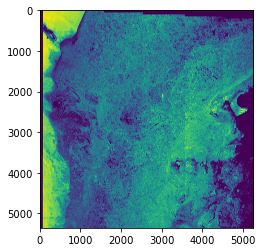

In [18]:
plt.imshow(n1[1])


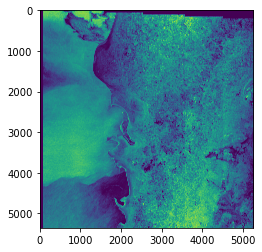

In [21]:
plt.imshow(n2[1])


In [22]:
mod_str = '-te 278603.1875 64568.3984375 826103.1875 774568.375 -tr 2500 2500'
dst_str = '-te 278603.1875 64568.3984375 826103.1875 774568.375 -tr 1000 1000'
pro_str = '+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06'

srs = NSR(pro_str)
mod_dom = Domain(srs, mod_str)
dst_dom = Domain(srs, dst_str)


In [27]:
s1_mod_dom = warp(n1, n1[1], mod_dom)
s1_dst_dom = warp(n1, n1[1], dst_dom)


In [28]:
s2_mod_dom = warp(n2, n2[1], mod_dom)
s2_dst_dom = warp(n2, n2[1], dst_dom)


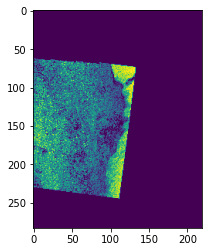

In [31]:
plt.imshow(s1_mod_dom)

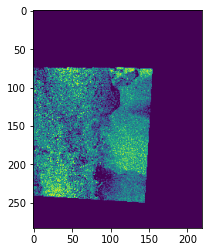

In [29]:
plt.imshow(s2_mod_dom)

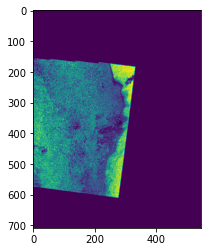

In [32]:
plt.imshow(s1_dst_dom)

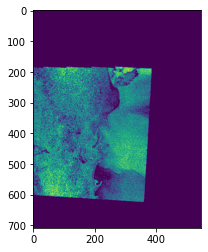

In [33]:
plt.imshow(s2_dst_dom)